Calculate Metrics
=================
Calculates a number of metrics for an already existing street graph with lanes before and after

Prerequisites: Prepare the street graph and rebuild it

In [1]:
import os, shutil

# Makes a local copy of current snman code
source_dir = os.path.join('C:',os.sep,'Users','lballo','polybox','GIT','github','snman','snman')
destination_dir = os.path.join('..','snman')
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

import snman
from snman.constants import *

PERIMETER = '_debug'

# Set these paths according to your own setup
data_directory = 'C:/Users/lballo/polybox/Research/SNMan/SNMan Shared/data_v2/'
inputs_path = data_directory + 'inputs/'
outputs_path = data_directory + 'outputs/' + PERIMETER + '/'
metrics_path = data_directory + 'metrics/' + PERIMETER + '/'

C:\Users\lballo\AppData\Roaming\Python\Python39\site-packages\osmnx\utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


Loading data
------------
Loads the street graph and measurement regions

In [2]:
print('Load measurement regions')
measurement_regions_gdf = snman.io.load_measurement_regions(inputs_path + 'measurement_regions/measurement_regions.gpkg',)
measurement_region = measurement_regions_gdf.iloc[0]

Load measurement regions


In [3]:
print('Load street graph')
G = snman.io.load_street_graph(outputs_path + 'G_edges.gpkg', outputs_path + 'G_nodes.gpkg')

Load street graph


In [4]:
# filter out the highways
#G_filtered = snman.street_graph.filter_by_hierarchy(G, snman.hierarchy.HIERARCHIES.difference(snman.hierarchy.HIGHWAY))

Calculating metrics
-------------------
This step will calculate a series of network metrics for lane graphs of different modes before and after rebuilding.
Please note that all calculations only work with strongly connected graphs. Therefore, all lane graphs will be automatically clipped only to the largest strongly connected component. Set *plot_scc=True* to show which parts of the graphs are removed (nodes are colored by their strongly connected component). Most likely, there will always be a few nodes that must be removed. But if they are many, then the results will be distorted.

For better accuracy, it's recommended that you adjust the perimeter of your network such that there are no nodes outside the largest connected component.

CARS BEFORE N deleted = 175 E deleted = 360


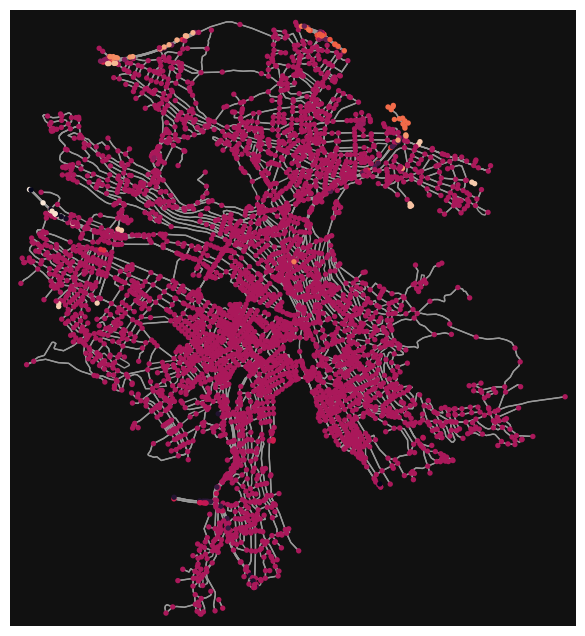

CARS AFTER N deleted = 238 E deleted = 439


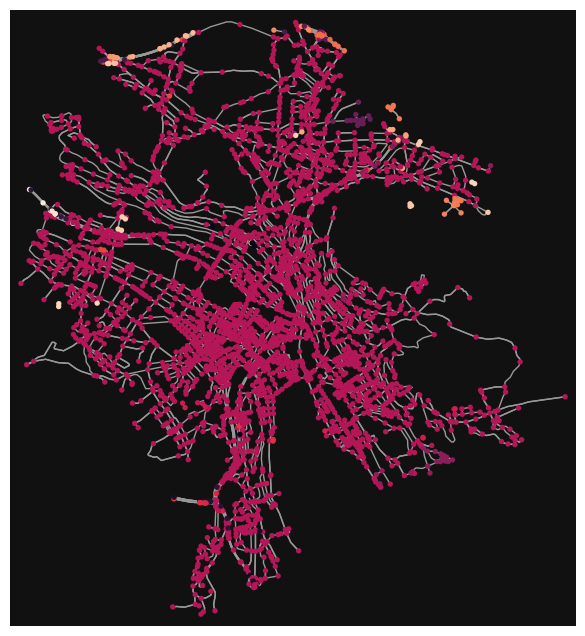

CYCLING BEFORE N deleted = 63 E deleted = 102


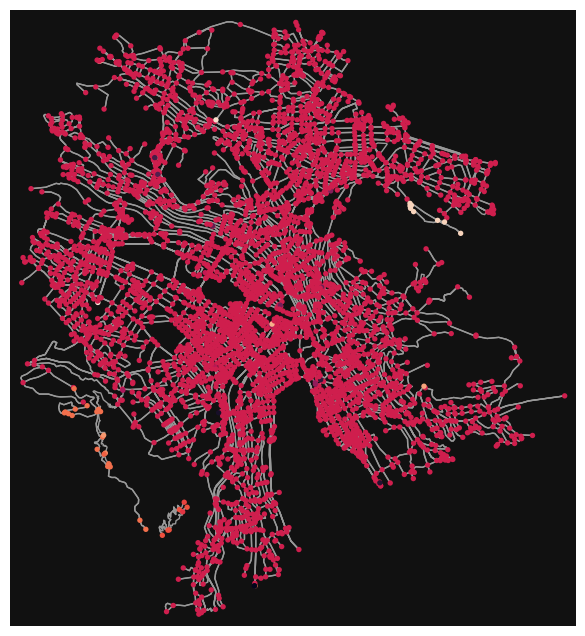

CYCLING AFTER N deleted = 59 E deleted = 97


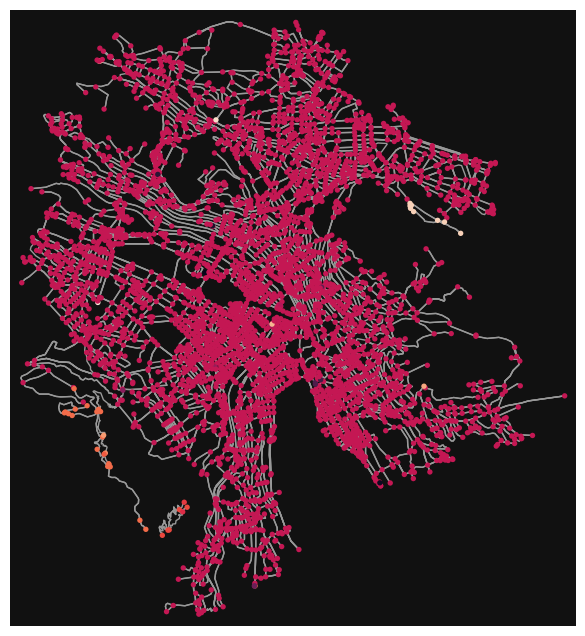

TRANSIT BEFORE N deleted = 174 E deleted = 359


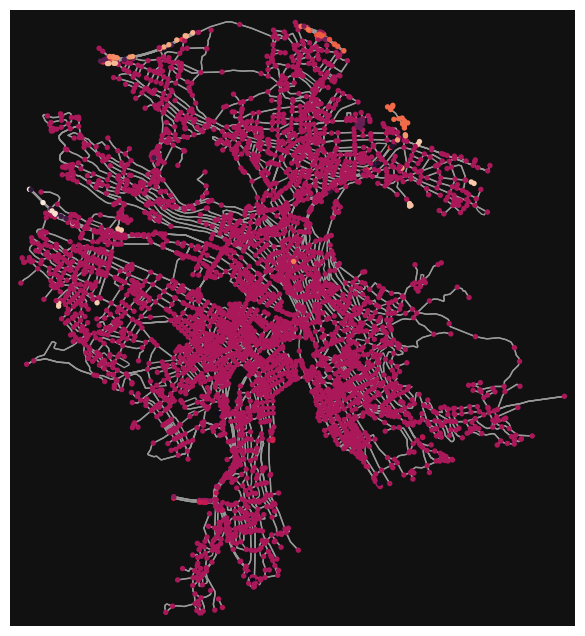

TRANSIT AFTER N deleted = 209 E deleted = 396


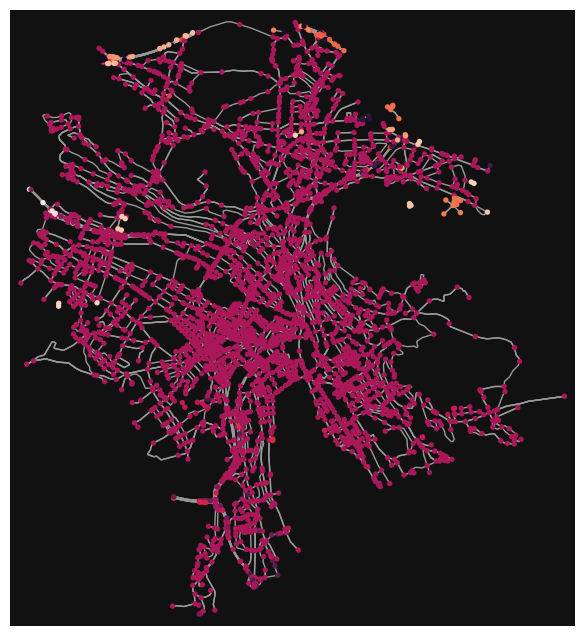

In [4]:
# calculate the metrics
metrics = snman.stats.network_metrics_for_all_measurement_regions(G, measurement_regions_gdf, plot_scc=True)

Viewing the metrics
-------------------
The metrics are saved as a dict of DataFrames, one for each measurement region.
See the docustring of snman.lane_graph.calculate_stats for an explanation of the measures.

In [7]:
metrics['zurich_city'].to_excel(metrics_path + 'metrics_zurich_city.xlsx', index=True)

In [8]:
#metrics['zurich_city'].to_excel(metrics_path + 'metrics_zurich_city.xlsx', index=True)

Area statistics by lane type

In [9]:
# Clip the street graph to the measurement region
H = snman.oxc.truncate.truncate_graph_polygon(
    G,
    measurement_region.geometry,
    quadrat_width=100, retain_all=True
)

In [12]:
import pandas as pd

def calculate_area_stats(G, lane_key):
    
    # Convert to lane graph
    L = snman.lane_graph.create_lane_graph(G, lanes_attribute=lane_key)
    #L = snman.graph.keep_only_the_largest_connected_component(L)
    
    # Convert the lane graph to GeoDataFrame and aggregate
    l = snman.oxc.graph_to_gdfs(L, nodes=False)
    l['area'] = l.apply(lambda row: row['length'] * row['lane'].width if row['instance'] == 1 else 0, axis=1)
    l['lanetype'] = l.apply(lambda row: row['lane'].lanetype, axis=1)
    
    aggregated = l.groupby('lanetype').agg({'area': 'sum'}) / 1000**2
    aggregated.rename(columns={'area': f'area_{lane_key}'}, inplace=True)
    aggregated = pd.DataFrame(aggregated)
    return aggregated

before = calculate_area_stats(H, KEY_LANES_DESCRIPTION)
after = calculate_area_stats(H, KEY_LANES_DESCRIPTION_AFTER)

area_stats = pd.merge(before, after, left_index=True, right_index=True)

area_stats.to_excel(os.path.join(metrics_path, 'area_stats.xlsx'))